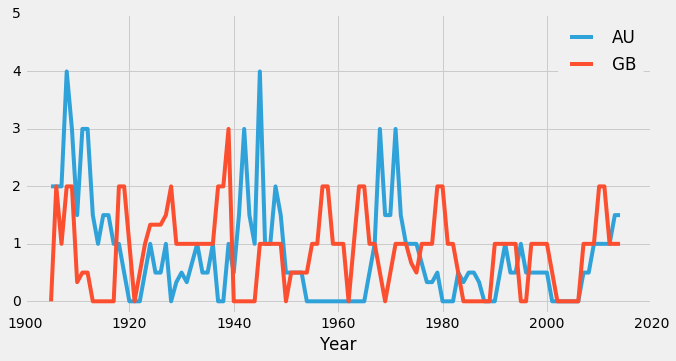

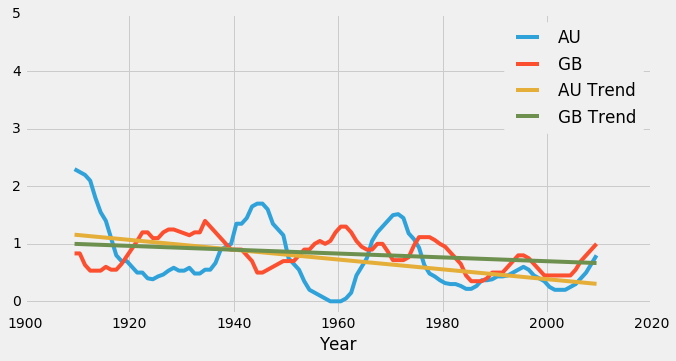

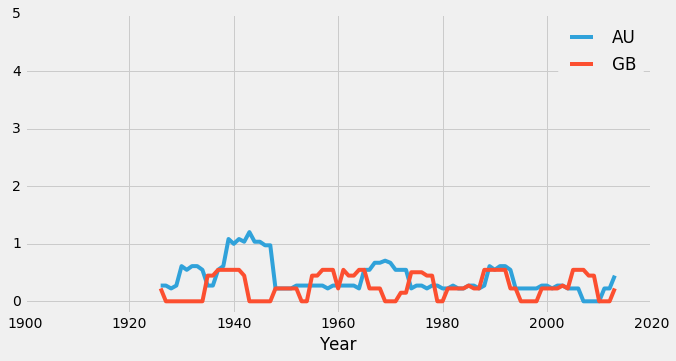

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as sm

plt.style.use('fivethirtyeight')
data = pd.read_csv("AU_GB_PMs.csv")

# data lists number of PMs / year
# total PMs including non-contiguous PMs is PM count - 1
au_pms_1901 = (data.AU_PM - 1).sum()
gb_pms_1901 = (data.GB_PM - 1).sum()
data1924 = data[data.Year >= 1924]
au_pms_1924 = (data1924.AU_PM - 1).sum()
gb_pms_1924 = (data1924.GB_PM - 1).sum()
au_elections_1924 = data1924.AU_Election.sum()
gb_elections_1924 = data1924.GB_Election.sum()
au_elections_1924_diff = (au_elections_1924 - gb_elections_1924) / gb_elections_1924 * 100.0

#apply a five year rolling window - total PMs to total elections
stepped_raw = list()
for index in range(5, len(data)):
    window = data[index-5:index]
    au = 0 if window.AU_Election.sum() == 0 else ((window.AU_PM - 1).sum() / window.AU_Election.sum())
    gb = 0 if window.GB_Election.sum() == 0 else ((window.GB_PM - 1).sum() / window.GB_Election.sum())
    stepped_raw.append({"Year": window.Year.max(),
                        "AU": au,
                        "GB": gb})
stepped = pd.DataFrame.from_records(stepped_raw)
fig1 = stepped.plot(x="Year", xlim=(1900, 2020), ylim=(-0.2, 5), figsize=(10, 5))
plt.savefig('pub/fig1.png')

#smooth with 10 year moving average
ma_10yr = stepped.rolling(window=10, center=True).mean()
ma_10yr["AU Trend"] = sm.ols(formula='AU ~ Year', data=ma_10yr).fit().fittedvalues
ma_10yr["GB Trend"] = sm.ols(formula='GB ~ Year', data=ma_10yr).fit().fittedvalues
fig2 = ma_10yr.plot(x="Year", xlim=(1900, 2020), ylim=(-0.2, 5), figsize=(10, 5))
plt.savefig('pub/fig2.png')

#compute yearly PM to election ratio (normalize to 1 per year) and compute 5 year rolling std dev.
volatility = pd.DataFrame(data={"AU": (data1924.AU_PM / (data1924.AU_Election + 1)),
                                "GB": (data1924.GB_PM / (data1924.GB_Election + 1)),
                                "Year": data1924.Year})
volatility["AU"] = volatility.AU.rolling(window=5, center=True).std()
volatility["GB"] = volatility.GB.rolling(window=5, center=True).std()
fig3 = volatility.plot(x="Year", xlim=(1900, 2020), ylim=(-0.2, 5), figsize=(10, 5))
plt.savefig('pub/fig3.png')


In [5]:
from jinja2 import Environment, FileSystemLoader
env = Environment(loader=FileSystemLoader("."), trim_blocks=True)
with open("pub/index.html", "w") as file:
    file.write(env.get_template('PM_stability.html').render(au_pms_1901=au_pms_1901, 
                                                            gb_pms_1901=gb_pms_1901, 
                                                            au_pms_1924=au_pms_1924, 
                                                            gb_pms_1924=gb_pms_1924,
                                                            au_elections_1924=au_elections_1924,
                                                            gb_elections_1924=gb_elections_1924,
                                                            au_elections_1924_diff=au_elections_1924_diff))
print("wrote index.html")


wrote index.html
